# Installing The Environment

In order to do any kind of analysis we need the right tools.
Here we are quickly going to install DeepChem and jupyter to work in for the rest of the workshop


```bash
# Install DeepChem
git clone https://github.com/lilleswing/deepchem-slim.git
bash scripts/install_deepchem_conda.sh future_of_care
source activate future_of_care
python setup.py install
cd ..

# Install jupyter
conda install jupyter jupyterlab

#Start your Notebook
jupyter lab
```

## What We Are Doing Today

https://pubs.acs.org/doi/abs/10.1021/acs.molpharmaceut.8b00110
This paper came across my radar last week.  
TODO (Some filler about why p450 is important)





# Grabbing The Data

Training Set
https://pubchem.ncbi.nlm.nih.gov/bioassay/1851

Test Sets
* https://pubchem.ncbi.nlm.nih.gov/bioassay/410
* https://pubchem.ncbi.nlm.nih.gov/bioassay/883
* https://pubchem.ncbi.nlm.nih.gov/bioassay/899
* https://pubchem.ncbi.nlm.nih.gov/bioassay/891
* https://pubchem.ncbi.nlm.nih.gov/bioassay/884


In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/AID_1851_datatable_all.csv')
curve_columns = list(filter(lambda x: x.find('CurveClass') > 0, df.columns.tolist()))
score_columns = list(filter(lambda x: x.find('Score') > 0, df.columns.tolist()))
ID_COLUMN = ['PUBCHEM_CID']
df = df[ID_COLUMN+curve_columns + score_columns]

/home/leswing/miniconda3/envs/cornell/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (0,7,9,10,12,13,15,16,17,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,42,43,44,45,46,47,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,66,67,69,70,71,72,73,74,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,93,94,96,97,98,99,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,120,121,123,124,125,126,127,128,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.columns.tolist()

['PUBCHEM_CID',
 'p450-cyp2c19-Fit_CurveClass',
 'p450-cyp2d6-Fit_CurveClass',
 'p450-cyp3a4-Fit_CurveClass',
 'p450-cyp1a2-Fit_CurveClass',
 'p450-cyp2c9-Fit_CurveClass',
 'Activity Score',
 'Activity Score.1',
 'Activity Score.2',
 'Activity Score.3',
 'Activity Score.4']

In [4]:
import math
def label_column(score, curve_class):
    # Convert Units
    score = float(score)
    curve_class = str(abs(float(curve_class)))
    
    if score >= 40 and curve_class in ("1.1", "1.2", "2.1"):
        return 1
    if curve_class in ("4.0") and score==0:
        return 0
    return -1

def read_smiles_lookup_map(fname):
    with open(fname) as fin:
        lines = fin.readlines()
        lines = [x.strip().split(',') for x in lines]
        d = {x[0]:x[1] for x in lines}
        return d
        

def df_to_single_task(df, score_column, curve_column):
    cids = df['PUBCHEM_CID'].tolist()[3:]
    curve_classes = df[curve_column].tolist()[3:]
    scores = df[score_column].tolist()[3:]
    
    smiles_lookup = read_smiles_lookup_map('data/smiles_lookup.csv')
    table = []
    for cid, curve_class, score in zip(cids, curve_classes, scores):
        if pd.isna(cid) or pd.isna(curve_class) or pd.isna(score):
            continue
        cid = str(int(cid))
        if cid not in smiles_lookup:
            continue
        smiles = smiles_lookup[cid]
        table.append([smiles,curve_class,score])
        
    final_table = []
    for smile, curve_class, score in table:
        label = label_column(score, curve_class)
        if label == -1:
            continue
        final_table.append([smile, str(label)])
    return final_table


In [5]:
table = df_to_single_task(df, 'Activity Score', 'p450-cyp2c19-Fit_CurveClass')
with open('assets/2c19_train.csv', 'w') as fout:
    for line in table:
        line = ",".join(line)
        fout.write("%s\n" % line)

In [6]:
# This doesn't line up with the paper!
# This is a very common thing in this field.....
y = [float(x[1]) for x in table]
len(y), sum(y),  len(y) - sum(y)

(10919, 5103.0, 5816.0)

In [7]:
import pandas as pd
df = pd.read_csv('data/AID_899_datatable_all.csv')
curve_columns = list(filter(lambda x: x.find('CurveClass') > 0, df.columns.tolist()))
score_columns = list(filter(lambda x: x.find('SCORE') > 0, df.columns.tolist()))
ID_COLUMN = ['PUBCHEM_CID']
df = df[ID_COLUMN+curve_columns + score_columns]

In [8]:
df.columns.tolist()

['PUBCHEM_CID', 'Fit_CurveClass', 'PUBCHEM_ACTIVITY_SCORE']

In [9]:
table = df_to_single_task(df, 'PUBCHEM_ACTIVITY_SCORE', 'Fit_CurveClass')

used_smiles = set()
with open('assets/2c19_train.csv') as fin:
    lines = [x.strip().split(',') for x in fin.readlines()]
    used = set([x[0] for x in lines])
    used_smiles.update(used)

unique_table = []
for line in table:
    if line[0] in used_smiles:
        continue
    unique_table.append(line)
table = unique_table
with open('assets/2c19_test.csv', 'w') as fout:
    for line in table:
        line = ",".join(line)
        fout.write("%s\n" % line)

In [10]:
y = [float(x[1]) for x in table]
len(y), sum(y),  len(y) - sum(y)

(722, 172.0, 550.0)

# What To Do WHen You Have Data

Now that we have the data and wish to do supervised learning we should first check out some aggregate statistics and attempt to visualize it

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import time
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rdkit import Chem
def load_dataset(fname):
    with open(fname) as fin:
        lines = [x.strip().split(',') for x in fin.readlines()]
        X, y = [], []
        for line in lines:
            X.append(Chem.MolFromSmiles(line[0]))
            y.append(float(line[1]))
        return X, y
X_train, y_train = load_dataset('assets/2c19_train.csv')
X_test, y_test = load_dataset('assets/2c19_test.csv')
        

# Lets look at some random molecules

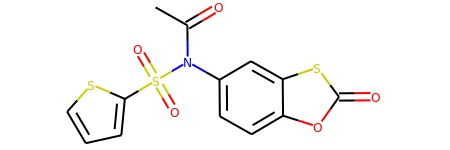

In [3]:
X_train[0]

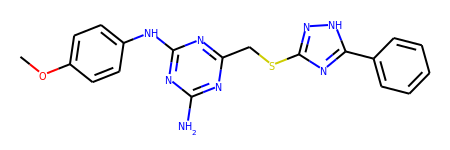

In [4]:
X_train[5]

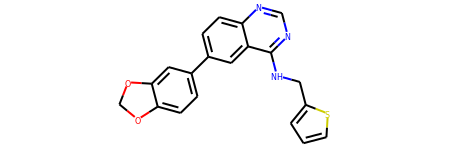

In [5]:
X_test[0]

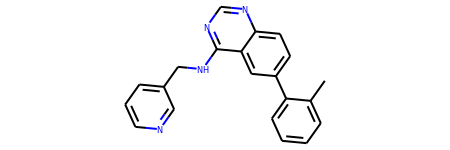

In [6]:
X_test[5]

(array([5.3264951, 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 4.6735049]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

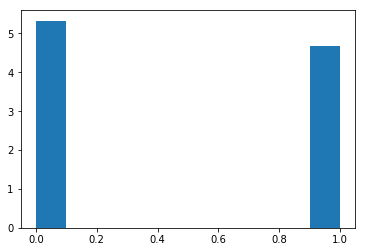

In [7]:
plt.hist(y_train, density=True)

(array([7.61772853, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 2.38227147]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

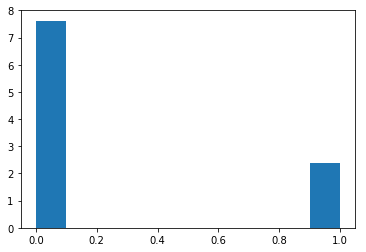

In [8]:
plt.hist(y_test, density=True)

## Lets plot the molecules in 2D

We have 11k molecules here.  With standard TSNE libraries this will take far too long to transform.
Instead we will install a faster tsne implementation
```bash
pip install MulticoreTSNE
```

In [9]:
import numpy as np
from deepchem.feat import CircularFingerprint
from MulticoreTSNE import MulticoreTSNE as TSNE

fingerprinter = CircularFingerprint()
fp_train = fingerprinter.featurize(X_train)
fp_test = fingerprinter.featurize(X_test)

In [15]:
fp_train.shape, fp_test.shape

((10919, 2048), (722, 2048))

In [10]:
import numpy as np

tsne = TSNE(n_jobs=4)
all_fps = np.concatenate([fp_train, fp_test], axis=0)
cp_coords = tsne.fit_transform(all_fps)

In [13]:
train_coords = cp_coords[:len(fp_train),:]
test_coords = cp_coords[len(fp_train):,:]

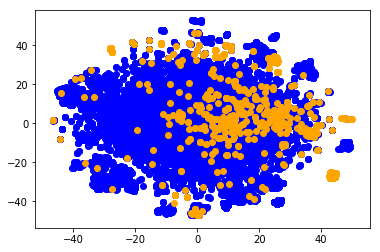

In [16]:
plt.scatter([x[0] for x in train_coords], [x[1] for x in train_coords], color='blue')
plt.scatter([x[0] for x in test_coords], [x[1] for x in test_coords], color='orange')

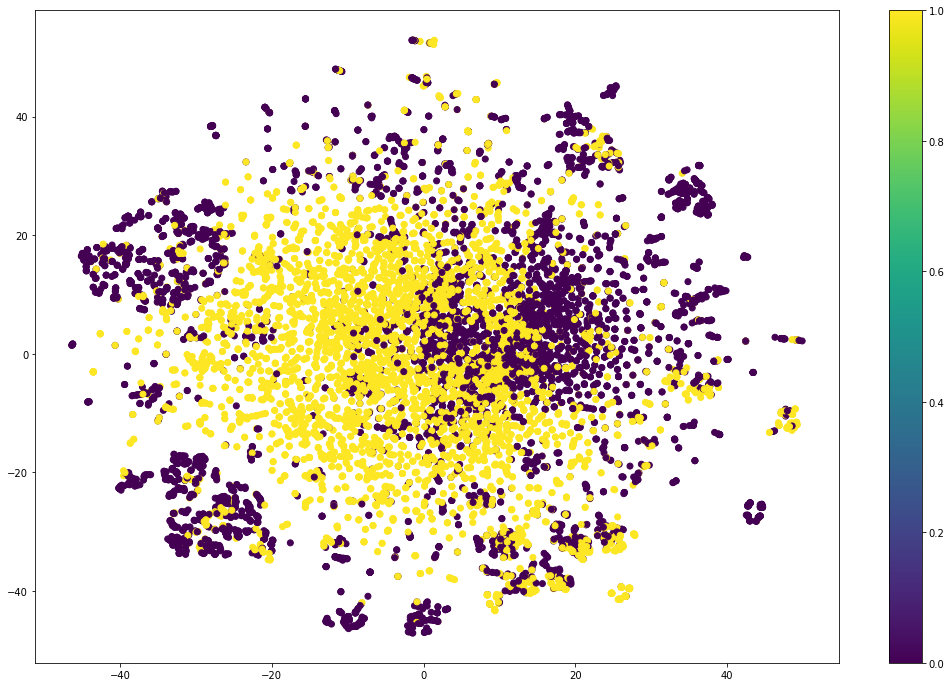

In [29]:
fig = plt.figure(figsize=(18,12))
colors = np.concatenate([y_train, y_test])
scat = plt.scatter([x[0] for x in cp_coords], [x[1] for x in cp_coords], c=colors)
fig.colorbar(scat)

## Lets also visualize with PCA

In [11]:
from sklearn.decomposition import PCA

In [31]:
pca = PCA(n_components=2)
cp_coords = pca.fit_transform(all_fps)

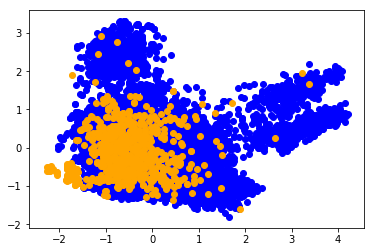

In [32]:
train_coords = cp_coords[:len(fp_train),:]
test_coords = cp_coords[len(fp_train):,:]
plt.scatter([x[0] for x in train_coords], [x[1] for x in train_coords], color='blue')
plt.scatter([x[0] for x in test_coords], [x[1] for x in test_coords], color='orange')

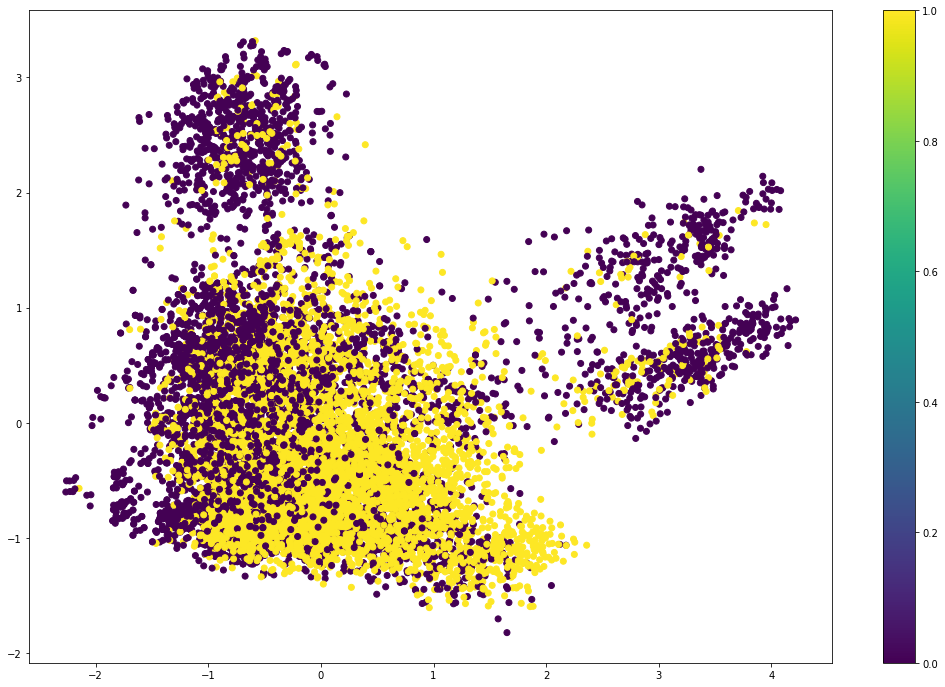

In [33]:
fig = plt.figure(figsize=(18,12))
colors = np.concatenate([y_train, y_test])
scat = plt.scatter([x[0] for x in cp_coords], [x[1] for x in cp_coords], c=colors)
fig.colorbar(scat)

# Set Baseline Model

# Lets Run Some Models!

If we are generating many models (Which we will) we need to set aside a cross validation set.  This helps to prevent over-fitting on the test dataset



In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
from rdkit import Chem
def load_dataset(fname):
    with open(fname) as fin:
        lines = [x.strip().split(',') for x in fin.readlines()]
        X, y = [], []
        for line in lines:
            X.append(Chem.MolFromSmiles(line[0]))
            y.append(float(line[1]))
        return X, y
X_train, y_train = load_dataset('assets/2c19_train.csv')
X_test, y_test = load_dataset('assets/2c19_test.csv')

In [2]:
import deepchem as dc
from deepchem.feat import CircularFingerprint

fingerprinter = CircularFingerprint()
train_dataset = dc.data.NumpyDataset(fingerprinter.featurize(X_train), y_train)
test_dataset = dc.data.NumpyDataset(fingerprinter.featurize(X_test), y_test)
splitter = dc.splits.RandomSplitter()
train_dataset, cv_dataset = splitter.train_test_split(train_dataset)

In [3]:
len(train_dataset), len(cv_dataset), len(test_dataset)

(8735, 2184, 722)

In [4]:
from deepchem.models import SklearnModel
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model = SklearnModel(model)

In [5]:
model.fit(train_dataset)
cv_predictions = model.predict(cv_dataset)

/home/leswing/miniconda3/envs/cornell/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [6]:
cv_predictions.shape

(2184, 2)

In [7]:
from sklearn.metrics import average_precision_score, roc_auc_score
print(average_precision_score(cv_dataset.y, cv_predictions[:,1]))
print(roc_auc_score(cv_dataset.y, cv_predictions[:,1]))

0.899201690733799
0.9257495389886867


In [8]:
test_predictions = model.predict(test_dataset)
print(average_precision_score(test_dataset.y, test_predictions[:,1]))
print(roc_auc_score(test_dataset.y, test_predictions[:,1]))

0.37675057804373946
0.7082346723044398


# Not So Good
This is called overfitting.  We performed very well on our training set but not so well on our test set.  Maybe our model is memorizing things about the training set instead of learning the true underlying function

In [9]:
splitter = dc.splits.ScaffoldSplitter()
train_smiles = [Chem.MolToSmiles(x, isomericSmiles=True) for x in X_train]
train_dataset = dc.data.NumpyDataset(X_train, y_train, ids=train_smiles)
test_dataset = dc.data.NumpyDataset(X_test, y_test)


In [10]:
splitter = dc.splits.ScaffoldSplitter()
train_dataset, cv_dataset = splitter.train_test_split(train_dataset)

In [11]:
featurizer = dc.feat.CircularFingerprint()
transformer = dc.trans.transformers.FeaturizationTransformer(transform_X=True, featurizer=featurizer)
train_feat, cv_feat = transformer.transform(train_dataset), transformer.transform(cv_dataset)

In [12]:
model = RandomForestClassifier()
model = SklearnModel(model)
model.fit(train_feat)
cv_predictions = model.predict(cv_feat)

/home/leswing/miniconda3/envs/cornell/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [13]:
print(average_precision_score(cv_dataset.y, cv_predictions[:,1]))
print(roc_auc_score(cv_dataset.y, cv_predictions[:,1]))

0.7115424647557287
0.8100729112273828


Not quite as bad as we did on the test set but closer, we can feel more comfortable smashing against this

# Lets try some Neural Networks

In [14]:
from deepchem.models import MultitaskClassifier
model = MultitaskClassifier(1, n_features=train_dataset.X.shape[-1])

In [15]:
model = MultitaskClassifier(1, n_features=train_feat.X.shape[-1])
train_scores = []
cv_scores = []
for i in range(20):
    model.fit(train_feat, nb_epoch=1)
    cv_predictions = model.predict(cv_feat)[:,0,1]
    cv_scores.append(average_precision_score(cv_dataset.y, cv_predictions))
    
    train_predictions = model.predict(train_feat)[:,0,1]
    train_scores.append(average_precision_score(train_dataset.y, train_predictions))


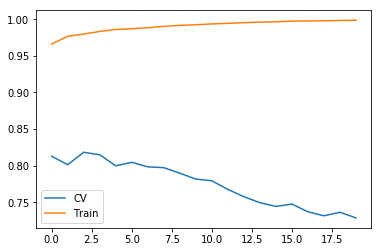

In [19]:
plt.plot(cv_scores)
plt.plot(train_scores)
plt.legend(['CV', 'Train'])

# Graph Convolutional Neural Networks

In [20]:
featurizer = dc.feat.ConvMolFeaturizer()
transformer = dc.trans.transformers.FeaturizationTransformer(transform_X=True, featurizer=featurizer)
train_feat, cv_feat = transformer.transform(train_dataset), transformer.transform(cv_dataset)

In [31]:
from deepchem.models import GraphConvModel
model = GraphConvModel(1, mode='classification')
train_scores = []
cv_scores = []
for i in range(10):
    model.fit(train_feat, nb_epoch=1)
    cv_predictions = model.predict(cv_feat)[:,0,1]
    cv_scores.append(roc_auc_score(cv_dataset.y, cv_predictions))
    
    train_predictions = model.predict(train_feat)[:,0,1]
    train_scores.append(roc_auc_score(train_dataset.y, train_predictions))

/home/leswing/miniconda3/envs/cornell/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


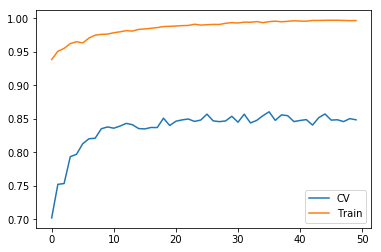

In [25]:
plt.plot(cv_scores)
plt.plot(train_scores)
plt.legend(['CV', 'Train'])

In [29]:
full_train_feat = transformer.transform(dc.data.NumpyDataset(X_train), y_train)
model = GraphConvModel(1, mode='classification')
model.fit(full_train_feat, nb_epoch=20)

/home/leswing/miniconda3/envs/cornell/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.0

# Model Interpretation

# Enumeration

In [42]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
%matplotlib inline
from rdkit import Chem
def load_dataset(fname):
    with open(fname) as fin:
        lines = [x.strip().split(',') for x in fin.readlines()]
        X, y = [], []
        for line in lines:
            X.append(Chem.MolFromSmiles(line[0]))
            y.append(float(line[1]))
        return X, y
X_train, y_train = load_dataset('assets/2c19_train.csv')
X_test, y_test = load_dataset('assets/2c19_test.csv')

In [33]:
from rdkit.Chem import FunctionalGroups
fgs = FunctionalGroups.BuildFuncGroupHierarchy()

In [34]:
from collections import namedtuple
nt = namedtuple('pattern','smarts mol')
def flattenFgs(fgs,res):
    if not fgs:
        return
    for x in fgs:
        res[x.label]=nt(x.smarts,x.pattern)
        flattenFgs(x.children,res)
allFgDefs={}
flattenFgs(fgs,allFgDefs)

In [38]:
allFgNames=sorted(allFgDefs.keys())
allFgs={}
for fgn in allFgNames:
    patt = allFgDefs[fgn]
    allFgs[fgn]=[m for m in X_train if m.HasSubstructMatch(patt.mol)]
    print('%s: Found %d '%(fgn,len(allFgs[fgn])))

AcidChloride: Found 0 
AcidChloride.Aliphatic: Found 0 
AcidChloride.Aromatic: Found 0 
Alcohol: Found 1825 
Alcohol.Aliphatic: Found 1394 
Alcohol.Aromatic: Found 576 
Aldehyde: Found 33 
Aldehyde.Aliphatic: Found 16 
Aldehyde.Aromatic: Found 17 
Amine: Found 5450 
Amine.Aliphatic: Found 3106 
Amine.Aromatic: Found 2979 
Amine.Cyclic: Found 2670 
Amine.Primary: Found 920 
Amine.Primary.Aliphatic: Found 498 
Amine.Primary.Aromatic: Found 432 
Amine.Secondary: Found 1811 
Amine.Secondary.Aliphatic: Found 628 
Amine.Secondary.Aromatic: Found 1211 
Amine.Tertiary: Found 2788 
Amine.Tertiary.Aliphatic: Found 1726 
Amine.Tertiary.Aromatic: Found 311 
Azide: Found 13 
Azide.Aliphatic: Found 10 
Azide.Aromatic: Found 3 
BoronicAcid: Found 1 
BoronicAcid.Aliphatic: Found 0 
BoronicAcid.Aromatic: Found 1 
CarboxylicAcid: Found 1017 
CarboxylicAcid.Aliphatic: Found 836 
CarboxylicAcid.AlphaAmino: Found 201 
CarboxylicAcid.Aromatic: Found 207 
Halogen: Found 2558 
Halogen.Aliphatic: Found 112 
Ha

In [43]:
from rdkit.Chem import AllChem
# Since there few boronic acids in the BB library from ZINC I can't do a Suzuki coupling, so I'll use N-arylation instead.
rxn = AllChem.ReactionFromSmarts('[a:1]-[Br,I].[N;H1;D2;$(N(-[#6])-[#6]);!$(N-[!#6;!#1]);!$(N-C=[O,N,S]):2]>>[a:1]-[N:2]')

RDKit ERROR: [16:11:28] non-ring atom 0 marked aromatic
RDKit ERROR: [16:11:28] non-ring atom 0 marked aromatic


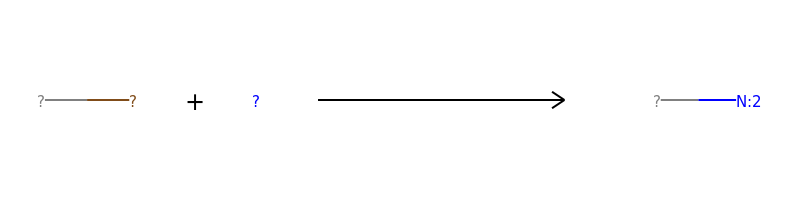

In [44]:
Draw.ReactionToImage(rxn)

In [45]:
halogens = allFgs['Halogen.NotFluorine.Aromatic']
amines = allFgs['Amine.Secondary']

In [47]:
products = AllChem.EnumerateLibraryFromReaction(rxn,(halogens,amines))

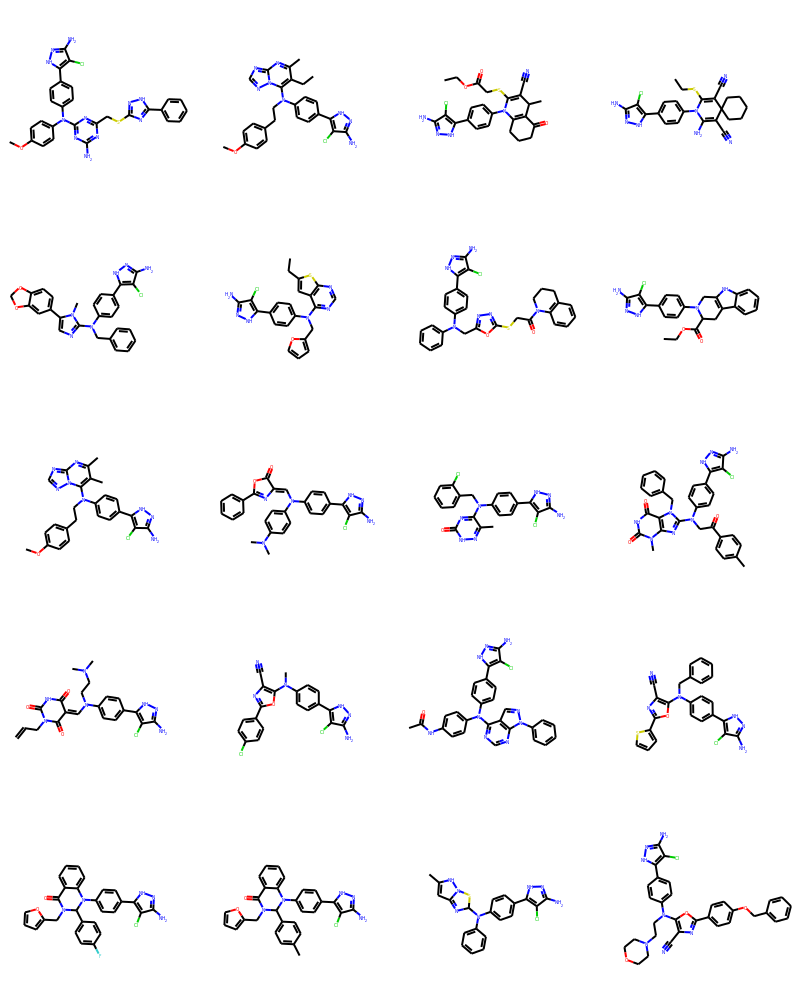

In [49]:
first20 = []
for p in products:
    first20.append(p[0])
    if len(first20) == 20:
        break
Draw.MolsToGridImage(first20,molsPerRow=4)

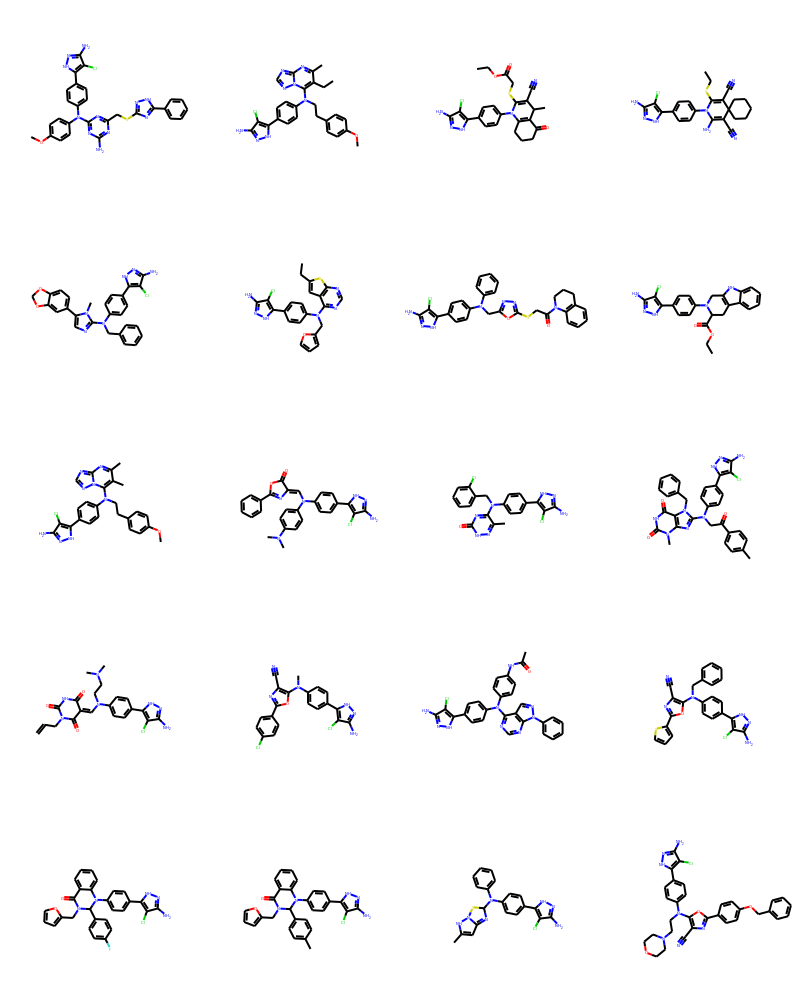

In [50]:
[Chem.SanitizeMol(x) for x in first20]
Draw.MolsToGridImage(first20,molsPerRow=4)

In [51]:
mols = []
for p in products:
    mols.append(p[0])
    if len(mols) == 1000:
        break

In [52]:
len(mols)

1000

In [54]:
import numpy as np
to_predict = dc.data.NumpyDataset(mols, np.ones(len(mols),))